In [1]:
import pandas as pd
import numpy as np

# Leemos los datos

In [2]:
missing_values = ['n/a', 'na']
df_train = pd.read_csv('titanic/train.csv', na_values = missing_values)
df_test = pd.read_csv('titanic/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
hist = df_train.hist(bins=20)

In [6]:
df_train['Title'] = df_train.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())
df_test['Title'] = df_test.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

df_train['Title'] = df_train['Title'].replace('Mlle', 'Miss')
df_train['Title'] = df_train['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df_train.Title.loc[ (df_train.Title !=  'Master') & (df_train.Title !=  'Mr') & (df_train.Title !=  'Miss') 
             & (df_train.Title !=  'Mrs')] = 'Others'


df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df_test.Title.loc[ (df_test.Title !=  'Master') & (df_test.Title !=  'Mr') & (df_test.Title !=  'Miss') 
             & (df_test.Title !=  'Mrs')] = 'Others'

df_train = pd.concat([df_train, pd.get_dummies(df_train['Title'])], axis=1).drop(labels=['Name'], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Title'])], axis=1).drop(labels=['Name'], axis=1)

# create a new feature "Family"
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1


df_train.Family = df_train.Family.map(lambda x: 0 if x > 4 else x)
df_test.Family = df_test.Family.map(lambda x: 0 if x > 4 else x)

df_train['Fare-bin'] = pd.qcut(df_train.Fare,5,labels=[1,2,3,4,5]).astype(int)
df_test['Fare-bin'] = pd.qcut(df_test.Fare,5,labels=[1,2,3,4,5]).astype(int)


/home/bea/.virtualenvs/python3.6-keras/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Limpiamos y procesamos los datos

In [7]:
def categorical_to_numerical(data_pd):
    data_pd['Sex'] = data_pd['Sex'].map({'male':0, 'female':1})
    data_pd['Embarked'] = data_pd['Embarked'].map({'C':0, 'Q':1, 'S':2})
    
    return data_pd

In [8]:
import pandas.api.types as ptypes

def test_categorical_to_numerical():
    df = pd.DataFrame({"PassengerId": [1, 2, 3],
                       "Sex": ['lala', 'male', 'female'],
                       "Embarked": ['S', 'C', 'Q']}) #,
                       # "hola": ['a', 'b', 'c']})
    
    df_cleaned = categorical_to_numerical(df)
    
    assert all(ptypes.is_numeric_dtype(df_cleaned[col]) for col in df_cleaned)
    # True
    # assert ptypes.is_string_dtype(df_cleaned['c'])
    # True
    # assert ptypes.is_datetime64_any_dtype(df_cleaned['d'])

test_categorical_to_numerical()

In [9]:
def clean_data(data_pd):
    cleaned_data = data_pd.dropna(axis=0)
    
    return cleaned_data

In [10]:
def test_clean_data():
    df = pd.DataFrame({"PassengerId": [1, np.nan, 3],
                       "Sex": [None, 'male', 'female'],
                       "Embarked": ['B', 'C', 'Q'],
                        "hola": ['null', 'b', 'c']})
    
    df_cleaned = clean_data(df)
    assert df_cleaned.isna().any().any() == False

test_clean_data()

In [11]:
def remove_duplicate_values(data_pd):
    return data_pd.drop_duplicates(keep='first', inplace=False)

In [12]:
def test_remove_duplicate_values():
    df = pd.DataFrame({"PassengerId": [1, np.nan, 3, 3],
                       "Sex": [None, 'male', 'female', 'female'],
                       "Embarked": ['B', 'C', 'Q', 'Q']})
    
    df_cleaned = remove_duplicate_values(df)
    assert (any(df_cleaned.duplicated())) == False
    
test_remove_duplicate_values()

In [13]:
df_train = categorical_to_numerical(df_train)
df_test = categorical_to_numerical(df_test)

df_train = clean_data(df_train)

In [14]:
df_train = df_train.drop(columns=['Title', 'Ticket', 'Cabin', 'PassengerId', 'Embarked', 'Pclass', 'SibSp', 'Parch'])
df_test = df_test.drop(columns=['Title','Ticket', 'Cabin', 'PassengerId', 'Embarked', 'Pclass', 'SibSp', 'Parch'])

# Matriz de correlacion

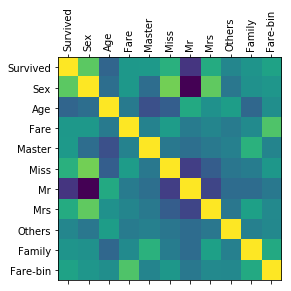

In [15]:
import matplotlib.pyplot as plt

plt.matshow(df_train.corr())
tick_marks = [i for i in range(len(df_train.columns))]
plt.xticks(tick_marks, df_train.columns, rotation='vertical')
plt.yticks(tick_marks, df_train.columns)
plt.show()

In [16]:
df_train.head()

,Survived,Sex,Age,Fare,Master,Miss,Mr,Mrs,Others,Family,Fare-bin
1,1,1,38.0,71.2833,0,0,0,1,0,2,5
3,1,1,35.0,53.1000,0,0,0,1,0,2,5
6,0,0,54.0,51.8625,0,0,1,0,0,1,5
10,1,1,4.0,16.7000,0,1,0,0,0,3,3
11,1,1,58.0,26.5500,0,1,0,0,0,1,4


# Definimos el modelo

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


In [18]:
y_train = df_train['Survived']
x_train = df_train.drop(columns=['Survived'])
feature_vector_length = x_train.shape[1]

# Red mal diseñada y test para arquitectura

In [19]:
def model_arquitecture():
    model = Sequential()
        
    # layers
    model = model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu', input_dim = feature_vector_length))
    model = model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
    model = model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
    model = model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    return model

In [20]:
model = model_arquitecture()

AttributeError: 'NoneType' object has no attribute 'add'

# Sobreentrenamos el modelo con mas neuronas

In [ ]:
def model_arquitecture():
    
    # Initialising the NN
    model = Sequential()

    # layers
    model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu', input_dim = feature_vector_length))
    model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

    # summary
    model.summary()
        
    adam = optimizers.Adam(lr=0.01, decay=1e-5)
    
    # Compiling the NN
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


In [ ]:
model = model_arquitecture()
feature_vector_length

In [ ]:
training = model.fit(x_train[:40], y_train[:40], epochs=1000, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
# Plot training & validation accuracy values
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Entrenamos con todo el dataset

In [ ]:
model_data = model_arquitecture()
training_data = model_data.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
# Plot training & validation accuracy values
plt.plot(training_data.history['loss'])
plt.plot(training_data.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Sobre entrenamos la red con menos neuronas

In [ ]:
def model_arquitecture2():
    model = Sequential()
    model.add(Dense(units=16, input_dim=feature_vector_length, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=4, activation='relu'))   
    model.add(Dense(units=1, activation='sigmoid'))
    # Compile model
    adam = optimizers.Adam(lr=0.01, decay=1e-5)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [ ]:
model2 = model_arquitecture2()
feature_vector_length

In [ ]:
training2 = model2.fit(x_train[:40], y_train[:40], epochs=600, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
# Plot training & validation accuracy values
plt.plot(training2.history['loss'])
plt.plot(training2.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Entrenamos con todo el dataset

In [ ]:
model2_data = model_arquitecture2()
training2_data = model2_data.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
# Plot training & validation accuracy values
plt.plot(training2_data.history['loss'])
plt.plot(training2_data.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Entrenamos el modelo

In [ ]:
model = model_arquitecture()
model.summary()

In [ ]:
training = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)